This is a DQN Network following along [this PyTorch tutorial](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html).
One takeaway here is that, a lot of the processes are added as research papes come out stating their effectivity. That answers a lot of the "why"s along the material.

# Install requirements (4 Colab)

In [ ]:
# check if running in colab
try:
    import google.colab
except:
    # not in colab
    pass
else:
    %pip install gymnasium

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Set-up

In [ ]:
# IMPORTS

import gymnasium as gym

import math
import random
from collections import namedtuple, deque
from itertools import count

import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from pprint import pprint

env = gym.make("CartPole-v1",)

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
# In interactive mode (enabled with plt.ion()):
# - newly created figures will be shown immediately;
# - figures will automatically redraw on change;
# - `pyplot.show` will not block by default.
plt.ion()

# import torch_directml
# # https://learn.microsoft.com/en-us/windows/ai/directml/gpu-pytorch-windows
# device = torch_directml.device()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


## Replay memory
A replay memory is basically a storage of all previous state transitions and their rewards.
[resource](https://deeplizard.com/learn/video/Bcuj2fTH4_4)

In [ ]:

# Experience memory: https://deeplizard.com/learn/video/Bcuj2fTH4_4
# At time t, the agent's experience e_t is defined as this tuple:
# e_t = (s_t, a_t, r_{t+1}, s_{t+1})    
# which gives us information about its current state, the action taken from state s_t, the reward at
# t+1, and the next state in the environment (at t+1). The last one, we won't know of course unless
# this experience is in at least 1 timestep in the past. (you can't see the future!)
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)
    
    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_sze):
        return random.sample(self.memory, batch_sze)

    def __len__(self):
        return len(self.memory)

## The model
The interesting thing is that we will be outputting the Q-value for the 2 available actions (move right/left), not necessarily the probability that they're to be chosen. The network is trying to predict the expected return of taking that action.

In [ ]:
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        # nn.Linear(in, uot) is like the "space" between 2 layers. it takes an input and maps it to neurons out.
        # resource https://www.sharetechnote.com/html/Python_PyTorch_nn_Linear_01.html
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)
    
    # x is a singular element: determine next action
    # x is a batch (multiple el.): for optimization (diff. word for training)
    # returns a tensor
    def forward(self, x):
        # basically, drive x through the whole network. Throughout this process, x may change its shape
        # ReLU(x) = max(0, x), comparable to sigmoid
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)
        
    

# Initializing, utils

In [ ]:
# HYPERPARAMETERS: constants that are set before the machine learning process begins
# eps. starting value
EPS_START = 0.9
# eps. target ending value at end of training
EPS_END = 0.05
# controls exponential decay of epsilon, higher is slower
EPS_DECAY = 1000
# learning rate for AdamW
LR = 1e-4
# n. of transitiosn sampled from ReplayMemory (aka. replay buffer)
BATCH_SIZE = 128
# discount factor on the Bellman equation
GAMMA = 0.99
# update reate for target network - lower is slower
TAU = 0.005

# get size of action space
n_actions = env.action_space.n
# https://gymnasium.farama.org/environments/classic_control/cart_pole/#observation-space
# this will return initial state parameters like pos, vel, etc. will be stochastically initialized
state, info = env.reset()
# size of state space
n_observations = len(state)

# why do we have 2 networks? -> https://stackoverflow.com/a/59869307
policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
# initialize target NN from policy NN - basically clone it -> https://pytorch.org/tutorials/beginner/saving_loading_models.html 
target_net.load_state_dict(policy_net.state_dict())

# AdamW is also called SGD or Stochastic Gradient Descent, you can look into it here:
# https://dev.to/amananandrai/10-famous-machine-learning-optimizers-1e22
# with `amsgrad=True`, we're using its variation:
# https://www.fast.ai/posts/2018-07-02-adam-weight-decay.html
# parameters are the variables we want to change over the training. Conveniently, they all get outputted on
# Module().parameters()
# a layer like nn.Linear() automatically randomly initializes them.
optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(capacity=10000)

steps_done = 0

def select_action(state):
    global steps_done
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-steps_done/EPS_DECAY)
    steps_done += 1
    sample = random.random()
    if sample > eps_threshold:
        with torch.no_grad():
            # Tensor.max returns us 2 parameters: 0. highest value, 1. highest value's index
            # Tensor.view(1, 1) turns the 1-dimensional into a 2D 1x1 tensor
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

episode_durations = []
def plot_durations(show_result=False):
    # every time we call plot_durations, we will create a new figure with ID = 1
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('result')
    else:
        plt.clf()
        plt.title('training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    if len(durations_t) >= 100:
        # takes 100 items from the tensor, get their mean
        #.view(-1) means that it should infer the size
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

# Optimizing
One thing that kind of surprised me is how detached this process is from the actual interaction with the environment. You basically just do it enough to have enough data on the ReplayMemory, then lock yourself away inside Optimization Bunker.

In [ ]:

def optimize_model():
    if len(memory) < BATCH_SIZE:
        # don't optimize yet, data population too smol!1
        return
    transitions = memory.sample(BATCH_SIZE)
    # turn [(a1, s1, r1), (a2, s2, r2), (an, sn, rn)] -> [(a1, a2, an), (s1, s2, sn), (r1, r2, rn)]
    # and then into Transition((a1, a2, an), (s1, s2, sn), (r1, r2, rn))
    batch = Transition(*zip(*transitions))

    # Transition(s, a, n_s, r) -> Transition(s, a, n_s, r), [for every action in a, Bool(is action non-final?)], n_s if not final
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    # filter list for non-Nones
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])

    # get one single batch for all states, actions, and rewards
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # get Q(s_t, a_t)
    # torch.gather(): https://stackoverflow.com/a/54706716
    # basically we input a bunch of states, select the corresponding actions we took in memory, 
    # and let the network calculate its expected Q-value for that action-state pair
    # this looks like a batch of values
    state_action_values = policy_net(state_batch).gather(1, action_batch)
    # get Q(s_t+1)
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        # Tensor[Boolean] is a quirky syntax - it'll get/set nothing if False - it's literally masking
        ''' 
        this is like zipping through all the tensors, and if at iteration n, non_final_mask[n] = False, then it will skip
        the value in non_final_mark[n]. This means that both can have different sizes, as long as the n. of Trues in the mask = n. of states
        in non_final_next_states.
        See the example below. We use C to mask B, while A is not the same shape at all:
        >>> a = torch.tensor([1, 2, 4])        
        >>> b = torch.tensor([5, 6, 7, 8]) 
        >>> c = torch.tensor([ True,  True, False,  True])
        >>> b[c] = a
        >>> b
        tensor([1, 2, 7, 4])
        '''
        # we use max(1) because we want to get the largest Q-value from each run of the NN - max([[1, 2], [3, 5]]) -> [2, 5] and NOT overall max 5!!
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
 
    '''
    This is an attempt to understand DQN with some analogies. Read with caution and suspicion, because they're probably wrong.
    So optimizing is like, 
    "so, mr. Model, at s_t+1 you predicted this value. then, for s_t, which is now, if you work it backwards, the value
    should be that of s_t+1, PLUS the current reward. "
    this suggests that the values become lower over time since we're using GAMMA in such a way that they converge to 0, since there's
    less and less reward over the course of time.
    the objective of a DQN is to get the most amount of reward, and not to converge to 0 the fastest. That will happen eventually, but it
    wants to stretch it as much as possible.
    At the moment, my visualization of the Q-values is as a chain that spans over time-steps and the nodes' values decrease as you approach the end.
    Then, the rewards are like these arrows poking it on the right direction.
    Also since we have a replay memory, that means that you force it to re-take the same actions as before, however,
    trying to predict a better maximum Q-value for states following it. It may not want to, but here you are,
    forcing it to do that. You are a monster.
    '''

    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    
    # a bit different from Huber loss - https://pytorch.org/docs/stable/generated/torch.nn.SmoothL1Loss.html#torch.nn.SmoothL1Loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
    # why call zero_grad()? - https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch  
    optimizer.zero_grad()
    # VERY GOOD explanation on loss.backward() and optimizer.step() - https://discuss.pytorch.org/t/what-does-the-backward-function-do/9944/2
    # basically, we do backpropragation so that all neurons will then have a gradient value.
    # we then use an optimizer on that gradient
    loss.backward()
    # we clip gradients to prevent potential exploding gradients - https://stackoverflow.com/a/67237834/15806103
    torch.nn.utils.clip_grad_value_(target_net.parameters(), 100)
    optimizer.step()

# Training loop

done!


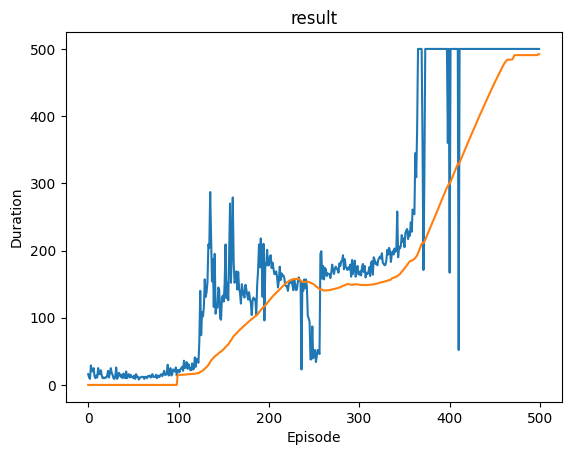

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 500

for i_episode in range(num_episodes):
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    # t will literally be the aount of time-steps here, as this loop will only break when we're done
    # larger is better
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        # reward *= 1-abs(observation[0]/4.8)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            # even if our state got truncated, this is fine because in next_state_values it'll be equivalent to 0 since it gets masked out
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
        
        memory.push(state, action, next_state, reward)

        state = next_state

        optimize_model()

        # TODO: learn what is soft update exactly & why
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            # we don't update target_net into policy_net fully - but rather gradually
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)
            
        if (steps_done % 1000) == 0:
            pass
            # if you want to visualize anything on the NN this is your chance
            # if len(memory) > 14:
            #     print(memory.sample(15))
            
        if done:
            episode_durations.append(t+1)
            plot_durations()
            break

print('done!')
plot_durations(show_result=True)
plt.ioff()
plt.show()
torch.save(target_net_state_dict, 'model-state-dict-'+str(random.randint(100, 999)))

# Evaluation

In [ ]:
target_net.load_state_dict(torch.load('model-state-dict'))
# https://stackoverflow.com/questions/60018578/what-does-model-eval-do-in-pytorch
target_net.eval()
with torch.no_grad():
    # TODO:
    pass